In [61]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

In [62]:
import plotly
import plotly.graph_objects as go
plotly.__version__

'4.1.1'

In [140]:
solvers.options['show_progress'] = False  # disable notifications about optimization progress
"""
Use internal CVXOPT type of matricies
"""
def opt_port(rets, ret_lim):
    n = rets.shape[0]
    means = np.mean(return_vec, axis=1) * 252
    
    # f = 0.5 * w *'COV* w + q'*w
    P = opt.matrix(np.cov(rets)) * 252
    q = opt.matrix(np.zeros((n, 1)))
    
    # w >= 0
    G = opt.matrix(-np.eye(n))
    h = opt.matrix(np.zeros((n, 1)))
    
    # sum(w) = 1
    # ret*w = ret_lim
    A = opt.matrix(np.vstack((np.ones((1, n)), means)))
    b = opt.matrix(np.array([[1], [ret_lim]])) 
    
    # Calculate efficient frontier weights using quadratic programming  
    x = solvers.qp(P, q, G, h, A, b)['x']  # return cxopt.matrix 

    ## CALCULATE RISKS AND RETURNS FOR FRONTIER  
    pret = blas.dot(opt.matrix(means), x)  # means.T * x
    prisk = np.sqrt(blas.dotu(x, P*x))  # x.T * P * x
    return x, pret, prisk

def min_vol(rets):
    n = rets.shape[0]
    means = np.mean(return_vec, axis=1) * 252
    
    # f = 0.5 * w *'COV* w + q'*w
    P = opt.matrix(np.cov(rets)) * 252
    q = opt.matrix(np.zeros((n, 1)))
    
    # w >= 0
    G = opt.matrix(-np.eye(n))
    h = opt.matrix(np.zeros((n, 1)))
    
    # sum(w) = 1
    # ret*w = ret_lim
    A = opt.matrix(np.ones((1, n)))
    b = opt.matrix(np.ones((1, 1)))
    
    # Calculate efficient frontier weights using quadratic programming  
    x = solvers.qp(P, q, G, h, A, b)['x']  # return cxopt.matrix 

    ## CALCULATE RISKS AND RETURNS FOR FRONTIER  
    pret = blas.dot(opt.matrix(means), x)  # means.T * x
    prisk = np.sqrt(blas.dotu(x, P*x))  # x.T * P * x
    return x, pret, prisk

In [111]:
# Maximize Sharpe ratio
def max_sharpe(efp, efp_rets, efp_std, rfrate):
    sratios = list(map(lambda r, s: (r-rfrate)/s, efp_rets, efp_std))
    k_opt = np.argmax(sratios)    
    return efp[k_opt], efp_rets[k_opt], efp_std[k_opt]

In [5]:
import sys
sys.path.append('../Portfolio/')

In [6]:
import quotes_download
from importlib import reload

In [7]:
stocks = ['AAPL','AMZN','GOOGL','FB', 'MSFT', 'INTC', 'IBM', 'WMT', 'VZ', 'V', 'BA']
dfs = quotes_download.tii_load_quotes_multi(stocks, '2015-01-01')

C:\Users\rsharapov\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning:

Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

C:\Users\rsharapov\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning:

Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

C:\Users\rsharapov\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning:

Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

C:\Users\rsharapov\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:847

In [71]:
data = dfs.pivot(index='date', columns='ticker', values='adjClose')
rets = data.pct_change()[1:]
return_vec = rets.to_numpy().T

In [72]:
return_vec.shape

(11, 1269)

In [74]:
p, r, s = min_vol(return_vec)
print(list(p))
print(r, s)

[0.04172453423005172, 1.2390279033666342e-06, 0.04084604799419675, 0.045524257763653014, 0.04478674510173237, 0.10509973083439207, 0.007815528263423641, 2.8257334363316165e-08, 0.10560093661549508, 0.3841078795519438, 0.22449307235987373]
0.1385124808926628 0.13022780050874064


In [137]:
def rand_weights(n):  
    k = np.random.rand(n)  
    return k / sum(k)

In [210]:
def random_portfolio(means, cov):  
    p = np.asmatrix(means) 
    w = np.asmatrix(rand_weights(means.shape[0]))  
    C = np.asmatrix(cov)
    
    mu = w * p.T  # Portfolio return
    sigma = np.sqrt(w * C * w.T)  # Portfolio sigma
    hhi = sum((np.array(w)**2)[0])
    return mu[0, 0], sigma[0, 0], hhi

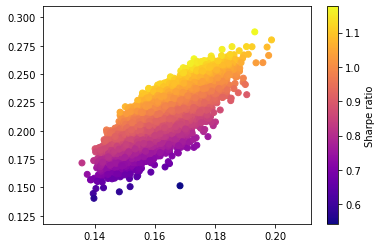

In [212]:
rfrate = 0.06

means0 = np.mean(return_vec, axis=1)*252
cov0 = np.cov(return_vec)*252

n_portfolios = 10000  
z = np.vstack([random_portfolio(means0, cov0) for _ in range(n_portfolios)])
means = z[:, 0]
stds = z[:, 1]
srs = (means - rfrate) / stds
nhhi = 1/z[:, 2]  # effective count of shares = 1/HHI

plt.scatter(x=stds, y=means, c=srs, cmap='plasma')  
plt.colorbar(label='Sharpe ratio')

In [244]:
rfrate = 0.06

preturns = []
prisks = []
eff_portfolios = []
psharpe = []
phhi = []
for ret_lim in np.linspace(0.1, 0.4, 100):
    pw, pret, pstd = opt_port(return_vec, ret_lim)
    eff_portfolios += [pw]
    preturns += [pret]
    prisks += [pstd]
    psharpe += [(pret-rfrate)/pstd]
    phhi += [1/sum(np.array(pw).T[0]**2)]
    
gmv, gmvret, gmvstd = min_vol(return_vec)
sr, srret, srstd = max_sharpe(eff_portfolios, preturns, prisks, rfrate)

In [245]:
eqw = np.array([1/len(stocks) for _ in range(len(stocks))])
eqret = np.dot(means0, eqw)
eqstd = np.sqrt(np.dot(np.dot(eqw.T, cov0), eqw))

eqw2, eqret2, eqstd2 = opt_port(return_vec, eqret)

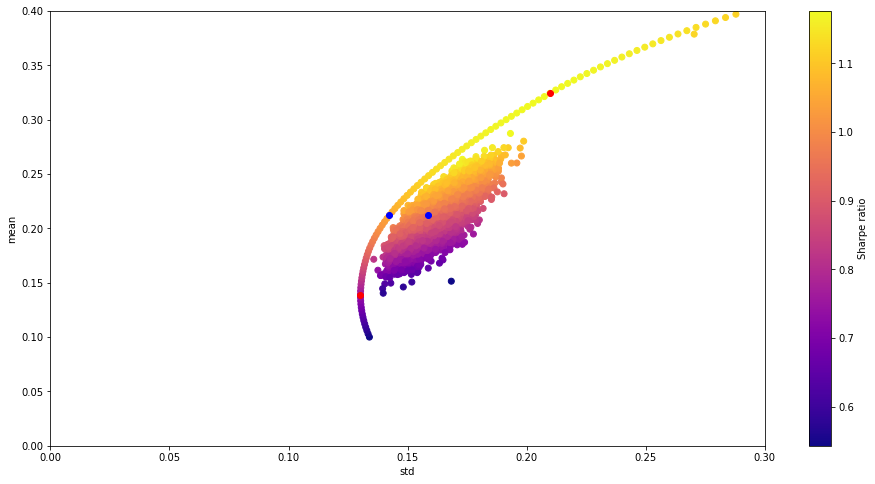

In [246]:
plt.figure(figsize=(16, 8))
plt.scatter(x=stds, y=means, c=srs, cmap='plasma')
plt.colorbar(label='Sharpe ratio')
plt.ylabel('mean')  
plt.xlabel('std')
plt.ylim(0, 0.4)
plt.xlim(0, 0.3)

plt.scatter(prisks, preturns, c=psharpe, cmap='plasma')
plt.plot(gmvstd, gmvret, 'r-o')
plt.plot(srstd, srret, 'r-o')

plt.plot(eqstd, eqret, 'b-o')

eqw2, eqret2, eqstd2 = opt_port(return_vec, eqret)
plt.plot(eqstd2, eqret2, 'b-o')

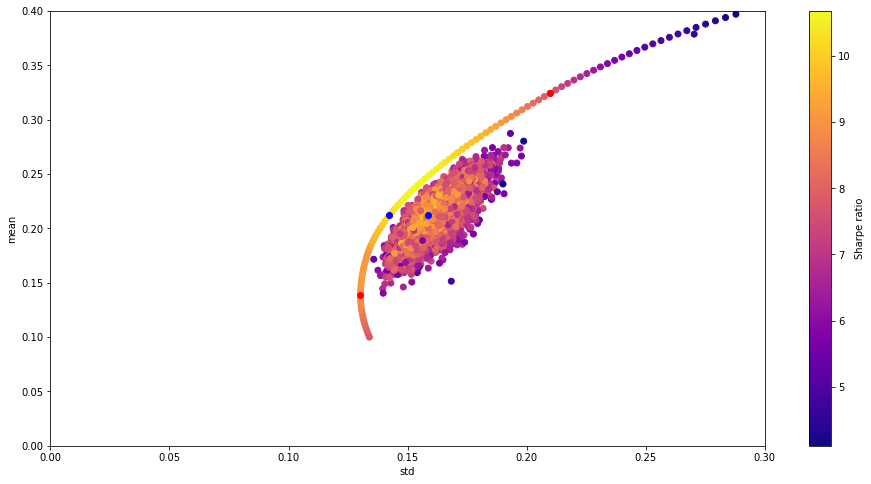

In [247]:
plt.figure(figsize=(16, 8))
plt.scatter(x=stds, y=means, c=nhhi, cmap='plasma')
plt.colorbar(label='Sharpe ratio')
plt.ylabel('mean')  
plt.xlabel('std')
plt.ylim(0, 0.4)
plt.xlim(0, 0.3)

plt.scatter(prisks, preturns, c=phhi, cmap='plasma')
plt.plot(gmvstd, gmvret, 'r-o')
plt.plot(srstd, srret, 'r-o')
plt.plot(eqstd, eqret, 'b-o')
plt.plot(eqstd2, eqret2, 'b-o')

5.558722088266681


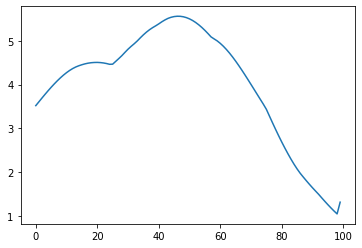

In [253]:
plt.plot(phhi)
print(max(phhi))

In [248]:
print('Global minimum volatility')
s = ['{0}: {1:0.3f}'.format(t, w) for t, w in zip(stocks, list(gmv))]
print(*s)

print('{0:0.4f}'.format(gmvret))
print('{0:0.4f}'.format(gmvstd))
print('{0:0.4f}'.format((gmvret-rfrate)/gmvstd))
print('1/HHI = {0:0.2f}'.format(1/sum(gmv**2)))

Global minimum volatility
AAPL: 0.042 AMZN: 0.000 GOOGL: 0.041 FB: 0.046 MSFT: 0.045 INTC: 0.105 IBM: 0.008 WMT: 0.000 VZ: 0.106 V: 0.384 BA: 0.224
0.1385
0.1302
0.6029
1/HHI = 4.39


In [249]:
print('Max Sharpe ratio')
s = ['{0}: {1:0.3f}'.format(t, w) for t, w in zip(stocks, list(sr))]
print(*s)

print('{0:0.4f}'.format(srret))
print('{0:0.4f}'.format(srstd))
print('{0:0.4f}'.format((srret-rfrate)/srstd))
print('1/HHI = {0:0.2f}'.format(1/sum(sr**2)))

Max Sharpe ratio
AAPL: 0.048 AMZN: 0.434 GOOGL: 0.136 FB: 0.000 MSFT: 0.000 INTC: 0.000 IBM: 0.000 WMT: 0.222 VZ: 0.151 V: 0.009 BA: 0.000
0.3242
0.2098
1.2594
1/HHI = 3.56


In [250]:
print('Equal-weights')
s = ['{0}: {1:0.3f}'.format(t, w) for t, w in zip(stocks, list(eqw))]
print(*s)

print('{0:0.4f}'.format(eqret))
print('{0:0.4f}'.format(eqstd))
print('{0:0.4f}'.format((eqret-rfrate)/eqstd))
print('1/HHI = {0:0.2f}'.format(1/sum(eqw**2)))

Equal-weights
AAPL: 0.091 AMZN: 0.091 GOOGL: 0.091 FB: 0.091 MSFT: 0.091 INTC: 0.091 IBM: 0.091 WMT: 0.091 VZ: 0.091 V: 0.091 BA: 0.091
0.2119
0.1587
0.9570
1/HHI = 11.00


In [251]:
print('Min vol like Equal-weights return')
s = ['{0}: {1:0.3f}'.format(t, w) for t, w in zip(stocks, list(eqw2))]
print(*s)

print('{0:0.4f}'.format(eqret2))
print('{0:0.4f}'.format(eqstd2))
print('{0:0.4f}'.format((eqret2-rfrate)/eqstd2))
print('1/HHI = {0:0.2f}'.format(1/sum(eqw2**2)))

Min vol like Equal-weights return
AAPL: 0.075 AMZN: 0.154 GOOGL: 0.090 FB: 0.008 MSFT: 0.000 INTC: 0.000 IBM: 0.000 WMT: 0.046 VZ: 0.179 V: 0.320 BA: 0.128
0.2119
0.1423
1.0671
1/HHI = 5.25
